# Alpha Vantage Data Analysis
An analysis of stock data from Alpha Vantage. Below, a specific stock is chosen.

In [1]:
ticker = 'AAPL'

Now, data is donwloaded for the stock and saved. Remember that Alpha Vantage has a limited amount of calls per day and minute!

In [36]:
import save_data_to_csv

save_data_to_csv.save_dataset(ticker)

## Adjusted Price and Volume Graphs
The data is imported from where it is saved and plotted.

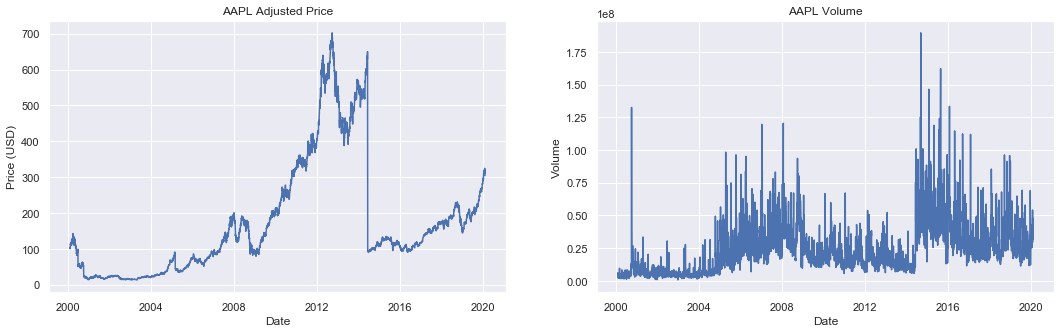

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get data and make a datetime index
data = pd.read_csv(f'./Stock Data/{ticker}_daily_adjusted.csv')
data.set_index(pd.to_datetime(data['date']), inplace=True)
data.drop(columns='date', inplace=True)

# Make graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(data.index, data.loc[:, '1. open'])
ax[0].set_title(ticker + ' Adjusted Price')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price (USD)')

ax[1].plot(data.index, data.loc[:, '6. volume'])
ax[1].set_title(ticker + ' Volume')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume');

## Technical Indicators
Techincal indicators are downloaded.

In [2]:
import save_ti_to_csv

save_ti_to_csv.save_ti(ticker)

Technial indicators are loaded in and added to the data

In [3]:
from os import listdir
from os.path import isfile, join

mypath = './Stock Data/TI'
onlyfiles = [f for f in listdir('./Stock Data/TI') if isfile(join(mypath, f))]

ti_fn = []
for f in onlyfiles:
    prefix = ticker + '_daily'
    if prefix == f[:len(prefix)]:
        ti_fn.append(f)

for f in ti_fn:
    d = pd.read_csv(f'./Stock Data/TI/{f}')
    d.set_index(pd.to_datetime(d['date']), inplace=True)
    d.drop(columns='date', inplace=True)
    if f[len(prefix) + 1:] == 'macdext.csv':
        data.join(d, rsuffix='ext')
    elif f[len(prefix) + 1:] == 'stochris.csv':
        data.join(d, rsuffix='ris')
    else:
        data = data.join(d)

data.dropna(inplace=True)

BBands are plotted for fun

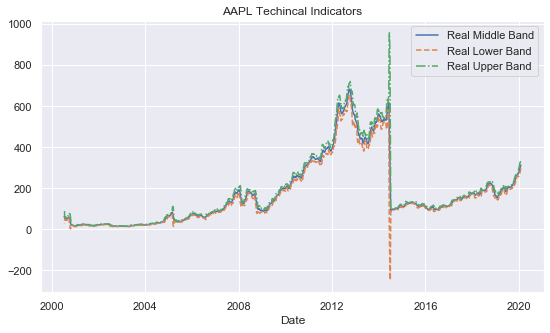

In [4]:
# Technical indicators plotted
plt.figure(figsize=(9, 5))
plt.plot(data.index, data['Real Middle Band'], label='Real Middle Band')
plt.plot(data.index, data['Real Lower Band'], label='Real Lower Band',
         linestyle='--')
plt.plot(data.index, data['Real Upper Band'], label='Real Upper Band',
         linestyle='-.')
plt.xlabel('Date')
plt.title(ticker + ' Techincal Indicators')
plt.legend();

## Predictive Modeling
Here, preditive modeling is perfromed on the data.
### Preprocessing
The data is preprocessed.

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Number of historical points needed to make next prediction
hist_num = 50

# Get data in an array without dates
X = data.loc['2016':].sort_index().values

# Make array of labels
y = np.array(X[hist_num + 1:, 4])
y = np.expand_dims(y, -1)

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
yscaler = StandardScaler()
y = yscaler.fit_transform(y)

# Get data ready for model. Model should make a predicton based on hist_num observations.
X = np.array([X[i:i+hist_num] for i in range(X.shape[0] - hist_num - 1)])

# Make sure we have the same amount of labels as observations
assert(y.shape[0] == X.shape[0])

# Split data into testing and training
n = data.loc['2016':'2017'].shape[0]
Xtrain = X[:n]
Xtest = X[n:]
ytrain = y[:n]
ytest = y[n:]

### Modeling
A LSTM nerual network is trained.

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,\
LSTM, Input, Activation, concatenate
from tensorflow.keras import optimizers
np.random.seed(4)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(4)
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential()
model.add(Input(shape=(hist_num, X.shape[2]), name='lstm_input'))
model.add(LSTM(hist_num, name='lstm_0'))
model.add(Dropout(0.2, name='lstm_dropout_0'))
model.add(Dense(64, name='dense_0'))
model.add(Activation('sigmoid', name='sigmoid_0'))
model.add(Dense(1, name='dense_1'))
model.add(Activation('linear', name='linear_output'))

model.compile(optimizer='adam', loss='mse')

# Train model
es = EarlyStopping('val_loss', patience=20)
fit = model.fit(x=Xtrain, y=ytrain, batch_size=X.shape[0], epochs=100,
          shuffle=True, validation_split=0.1, verbose=1, callbacks=[es]);

Using TensorFlow backend.


Epoch 1/100


Here is a visualization of the fit history.

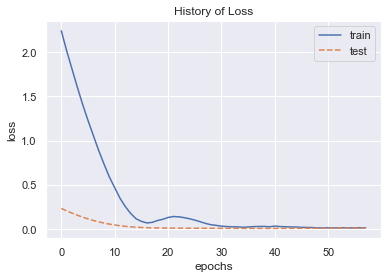

In [8]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], '--', label='test',)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('History of Loss')
plt.legend();

### Evaluation
The model is evaluated on the test data.

In [9]:
evaluation = model.evaluate(Xtest, ytest, verbose=0)
print(f'The evaluation score is {evaluation}.')

The evaluation score is 0.6723366089905544.


Now we plot the predicted price next to the actual.

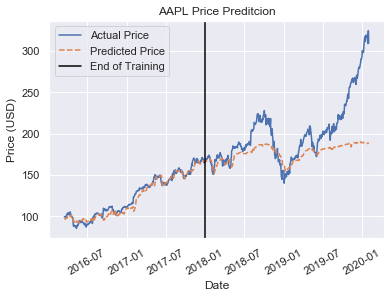

In [10]:
# Predict
ypred = yscaler.inverse_transform(model.predict(X))

# Get actual data to plot
yplot = yscaler.inverse_transform(y)
assert(np.allclose(yplot.flatten(), data.loc['2016':].iloc[hist_num + 1:, 4]))


# Plot price and prediction
plt.plot(data.loc['2016':].index[hist_num + 1:], yplot, label='Actual Price')
plt.plot(data.loc['2016':].index[hist_num + 1:], ypred, '--',
         label='Predicted Price')

# Plot line to denote end of training
plt.axvline(data.loc['2017'].index[-1], c='black', label="End of Training")

# Title and labels
plt.title(ticker + " Price Preditcion")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30)
plt.legend();

### Algorithmic Trading
The model is used to trade stocks.

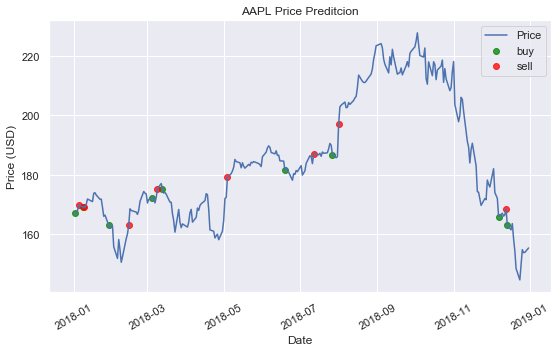

In [17]:
# Get prices during time of interest
timeframe = '2018'
p = data.loc[timeframe].iloc[:,4].values

# Calculate predicted change in price
num_points = p.size
delta_y = ypred[n: n + num_points].flatten() - p

# Arrays to indicate whether to buy or sell
buy = np.zeros_like(delta_y, dtype=bool)
sell = buy.copy()

# Decide whether to buy or sell
up = None
if delta_y[0] >= 0:
    buy[0] = True
    up = True
else:
    sell[0] = True
    up = False
for i in range(1, buy.size):
    if delta_y[i] >= 0:
        if not up:
            buy[i] = True
        up = True
    else:
        if up:
            sell[i] = True
        up = False

# Get days of when to buy or sell
d = data.loc[timeframe].index
dbuy = d[buy]
dsell = d[sell]

# Get what price to buy and sell at
pbuy = p[buy]
psell = p[sell]

# Plot price, buy, and sell
plt.figure(figsize=(9,5))
plt.plot(d, p, label='Price')
plt.scatter(dbuy, pbuy, c='green', label='buy', alpha=.75)
plt.scatter(dsell, psell, c='red', label='sell', alpha=.75)

# Title and labels
plt.title(ticker + " Price Preditcion")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30)
plt.legend();

### Evaluation
Know we see how much money was made by the simulated trading versus, the change in the actual price.

In [24]:
dbuy[:-1] < dsell

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [22]:
dsell

DatetimeIndex(['2018-01-05', '2018-01-09', '2018-02-14', '2018-03-09',
               '2018-05-04', '2018-07-12', '2018-08-01', '2018-12-13'],
              dtype='datetime64[ns]', name='date', freq=None)

In [30]:
# Total change in price
delta_p = p[-1] - p[0]

# Money made by algorithm
if dbuy[0] < dsell[0]:
    if dbuy.shape == dsell.shape:
        delta_m = np.sum(psell - pbuy)
    else:
        delta_m = np.sum(psell - pbuy[:-1])
else:
    if dbuy.shape == dsell.shape:
        delta_m = np.sum(psell[1:] - pbuy[:-1])
    else:
        delta_m = np.sum(psell[1:] - pbuy)

# APY
apy_m = delta_m/pbuy[0] * 100
apy_p = delta_p/p[0] * 100

# Print results
print(f'The price of AAPL changed by {delta_p} USD when the algorithm made {delta_m} USD over {timeframe}.')
print(f'The AAPL market had a return of {apy_p} %, when the algorithm had a return of {apy_m} % in {timeframe}.')

The price of AAPL changed by -11.796300000000002 USD when the algorithm made 27.501600000000053 USD over 2018.
The AAPL market had a return of -7.055448095687532%, when the algorithm had a return of 16.44889595452477% in 2018.
